In [2]:
import numpy as np
from nilearn.masking import apply_mask
from nilearn.image import load_img,resample_to_img,math_img

In [ ]:
# load roi
HCl = load_img(r'/mnt/workdir/DCM/docs/Reference/Park_Grid_Coding/osfstorage-archive/data/Analysis_ROI_nii/HCl_roi.nii')
HCr = load_img(r'/mnt/workdir/DCM/docs/Reference/Park_Grid_Coding/osfstorage-archive/data/Analysis_ROI_nii/HCr_roi.nii')

EC_grid = load_img(r'/mnt/workdir/DCM/docs/Reference/Park_Grid_Coding/osfstorage-archive/data/Analysis_ROI_nii/EC_Grid_roi.nii')

ECl  = load_img(r'/mnt/workdir/DCM/docs/Reference/Park_Grid_Coding/osfstorage-archive/data/Analysis_ROI_nii/ECl_roi.nii')
ECr = load_img(r'/mnt/workdir/DCM/docs/Reference/Park_Grid_Coding/osfstorage-archive/data/Analysis_ROI_nii/ECr_roi.nii')

# load stats map
game1_cmap = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/separate_hexagon/Setall/group/covariates/'
                          r'age/2ndLevel/_contrast_id_ZF_0006/con_0002.nii')
game2_cmap = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game2/separate_hexagon/Setall/group/covariates/'
                          r'age/2ndLevel/_contrast_id_ZF_0006/con_0002.nii')


# apply mask
HCl,HCr,EC_grid,ECl,ECr = [resample_to_img(mask, game1_cmap,interpolation='nearest')
                                       for mask in [HCl,HCr,EC_grid,ECl,ECr]]


contrast_map = math_img("img1-img2",img1=game1_cmap,img2=game2_cmap)
# game1
rois = ['HCl','HCr','EC_grid','ECl','ECr']
game1_means = []
game1_std = []

for roi in rois:
    betas = apply_mask(imgs=contrast_map, mask_img=eval(roi))
    betas[betas==0] = np.nan
    game1_means.append(np.nanmean(betas))
    game1_std.append(np.nanstd(betas))

#
game2_means = []
game2_std = []
for roi in rois:
    betas = apply_mask(imgs=game2_acc_cmap, mask_img=eval(roi))
    betas[betas==0] = np.nan
    game2_means.append(np.nanmean(betas))
    game2_std.append(np.nanstd(betas))


import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(7,7))

x = np.arange(len(rois))  # the label locations
width = 0.35  # the width of the bars

ax.bar(x - width/2, game1_means, width, yerr=game1_std, label='Game1')
ax.bar(x + width/2, game2_means, width, yerr=game2_std, label='Game2')

ax.set_xticks(x) # values
ax.set_xticklabels(rois) # labels
ax.set_ylabel('Beta')
ax.set_title('Difference between game1 and game2 in HC and EC')

ax.legend()


fig.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

penguins = sns.load_dataset("penguins")

# Draw a nested barplot by species and sex
g = sns.catplot(kind=['game1']*5+['game2']*5,
    x=rois*2, y=game1_means+game2_means, hue="sex",
    ci="sd", palette="dark", alpha=.6, height=6
)

In [75]:
# roi analysis -
import os
import pandas as pd

stats_path = r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game2/alignGame1/vmpfc-group/Setall/6fold/{}/spmT_0003.nii'
roi_path = r'/mnt/workdir/DCM/docs/Reference/Park_Grid_ROI/mPFC_Grid_roi.nii'

save_path = r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game2/alignGame1/vmpfc-group/roi_result/hexagonal_modulation_average_betas_algin_game1.csv'

# set subject list
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game2_fmri==1')
pid = data['Participant_ID'].to_list()
subjects = [p.replace('_', '-') for p in pid]

folds = range(6,7)

sub_fold_beta = pd.DataFrame(columns=['sub_id','amplitude'])

for sub in subjects:
    stats_map = stats_path.format(sub)
    roi_img = load_img(roi_path)
    roi_img = resample_to_img(roi_img, stats_map,interpolation='nearest')
    amplitude = np.nanmean(apply_mask(imgs=stats_map, mask_img=roi_img))

    sub_tmp = sub.replace('-','_')
    age = data.loc[data.Participant_ID==sub_tmp,'Age'].values[0]
    game1_acc = data.loc[data.Participant_ID==sub_tmp,'game1_acc'].values[0]
    game2_acc = data.loc[data.Participant_ID==sub_tmp,'game2_test_acc'].values[0]
    tmp_data = {'sub_id': sub, 'amplitude': amplitude,'age':age,'game1_acc':game1_acc,'game2_acc':game2_acc}
    sub_fold_beta = sub_fold_beta.append(tmp_data, ignore_index=True)
sub_fold_beta.to_csv(save_path,index=False)

In [69]:
# roi analysis - individual roi
import os
import pandas as pd

stats_path = r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game2/alignGame1/EC-individual/Setall/6fold/{}/spmT_0002.nii'
roi_path = r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game1/defROI/EC/individual/{}_EC_func_roi.nii'
save_path = r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/game2/alignGame1/EC-individual/roi_result/hexagonal_modualtion_decision_betas_algin_game1.csv'

# set subject list
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game2_fmri==1')
data['game2_training_acc'] = (data['game2_train_ap'] + data['game2_train_ap'])/2
pid = data['Participant_ID'].to_list()
subjects = [p.replace('_', '-') for p in pid]

folds = range(6,7)

sub_fold_beta = pd.DataFrame(columns=['sub_id','amplitude'])

for sub in subjects:
    stats_map = stats_path.format(sub)
    roi_img = load_img(roi_path.format(sub.split('-')[-1]))
    roi_img = resample_to_img(roi_img, stats_map,interpolation='nearest')
    amplitude = np.nanmean(apply_mask(imgs=stats_map, mask_img=roi_img))

    sub_tmp = sub.replace('-','_')
    age = data.loc[data.Participant_ID==sub_tmp,'Age'].values[0]
    game1_acc = data.loc[data.Participant_ID==sub_tmp,'game1_acc'].values[0]
    game2_train_acc = data.loc[data.Participant_ID==sub_tmp,'game2_training_acc'].values[0]
    game2_acc = data.loc[data.Participant_ID==sub_tmp,'game2_test_acc'].values[0]
    tmp_data = {'sub_id': sub, 'amplitude': amplitude,'age':age,'game1_acc':game1_acc,
                'game2_train_acc':game2_train_acc,'game2_acc':game2_acc}
    sub_fold_beta = sub_fold_beta.append(tmp_data, ignore_index=True)
sub_fold_beta.to_csv(save_path,index=False)

<ipython-input-69-7a0fe009cfd4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['game2_training_acc'] = (data['game2_train_ap'] + data['game2_train_ap'])/2


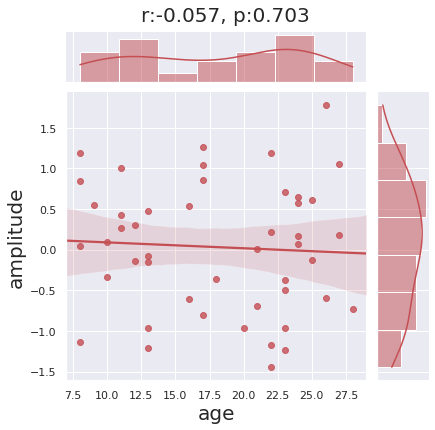

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

sns.set_theme(style="darkgrid")
#sns.set_context("talk")

data = pd.read_csv(save_path)
#correlation
res = pearsonr(data['age'],data['amplitude'])
r = res[0]
p = res[1]

# plot
g = sns.jointplot(x="age", y="amplitude", data=data,
                  kind="reg", truncate=False,
                  #xlim=(7, 30), ylim=(0, 1),
                  color="r", height=6)
#move overall title up
g.set_axis_labels('age', 'amplitude',size=20)
g.fig.subplots_adjust(top=0.92)
if p < 0.001:
    g.fig.suptitle('r:{}  p<0.001'.format(round(r,3)),size=20)
else:
    g.fig.suptitle('r:{}, p:{}'.format(round(r,3),round(p,3)),size=20)

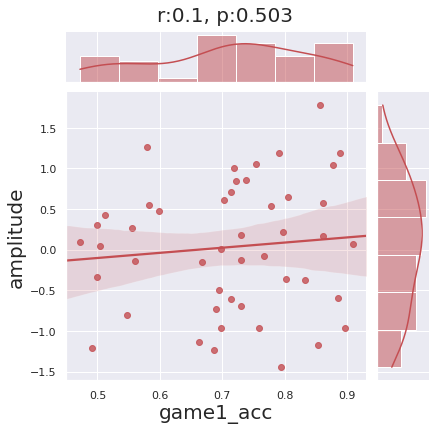

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

#sns.set_theme(style="darkgrid")
#sns.set_context("talk")

data = pd.read_csv(save_path)
#correlation
res = pearsonr(data['game1_acc'],data['amplitude'])
r = res[0]
p = res[1]

# plot
g = sns.jointplot(x="game1_acc", y="amplitude", data=data,
                  kind="reg", truncate=False,
                  #xlim=(7, 30), ylim=(0, 1),
                  color="r", height=6)
#move overall title up
g.set_axis_labels('game1_acc', 'amplitude',size=20)
g.fig.subplots_adjust(top=0.92)
if p < 0.001:
    g.fig.suptitle('r:{}  p<0.001'.format(round(r,3)),size=20)
else:
    g.fig.suptitle('r:{}, p:{}'.format(round(r,3),round(p,3)),size=20)

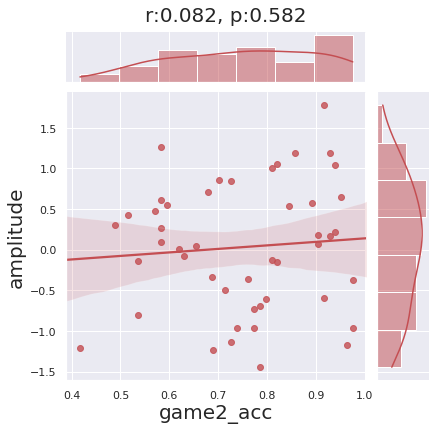

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

#sns.set_theme(style="darkgrid")
#sns.set_context("talk")

data = pd.read_csv(save_path)
#correlation
res = pearsonr(data['game2_acc'],data['amplitude'])
r = res[0]
p = res[1]

# plot
g = sns.jointplot(x="game2_acc", y="amplitude", data=data,
                  kind="reg", truncate=False,
                  #xlim=(7, 30), ylim=(0, 1),
                  color="r", height=6)
#move overall title up
g.set_axis_labels('game2_acc', 'amplitude',size=20)
g.fig.subplots_adjust(top=0.92)
if p < 0.001:
    g.fig.suptitle('r:{}  p<0.001'.format(round(r,3)),size=20)
else:
    g.fig.suptitle('r:{}, p:{}'.format(round(r,3),round(p,3)),size=20)

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

#sns.set_theme(style="darkgrid")
#sns.set_context("talk")

data = pd.read_csv(save_path)
#correlation
res = pearsonr(data['game2_train_acc'],data['amplitude'])
r = res[0]
p = res[1]

# plot
g = sns.jointplot(x="game2_train_acc", y="amplitude", data=data,
                  kind="reg", truncate=False,
                  #xlim=(7, 30), ylim=(0, 1),
                  color="r", height=6)
#move overall title up
g.set_axis_labels('game2_train_acc', 'amplitude',size=20)
g.fig.subplots_adjust(top=0.92)
if p < 0.001:
    g.fig.suptitle('r:{}  p<0.001'.format(round(r,3)),size=20)
else:
    g.fig.suptitle('r:{}, p:{}'.format(round(r,3),round(p,3)),size=20)

KeyError: 'game2_train_acc'